In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=55ac79a81d6bece1f5f9cc88487323f85dd53b10eb5fbed54210e39d6bfdd12c
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Step 1: Initialize Spark Session

In [2]:
spark = SparkSession.builder \
    .appName("FinancialFraudDetection") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.kryoserializer.buffer.max", "2047mb") \
    .getOrCreate()

# Step 2: Load Data


In [3]:
file_path = "/content/drive/MyDrive/PS_20174392719_1491204439457_log.csv"
data = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)


# Sample a subset of the data for initial testing

In [4]:
data_sample = data.sample(False, 0.1, seed=42)

# Step 3: Preprocess Data
# Convert categorical columns to numerical

In [5]:
indexers = [
    StringIndexer(inputCol="type", outputCol="typeIndex"),
    StringIndexer(inputCol="nameOrig", outputCol="nameOrigIndex"),
    StringIndexer(inputCol="nameDest", outputCol="nameDestIndex")
]

for indexer in indexers:
    data_sample = indexer.fit(data_sample).transform(data_sample)

# Assemble features into a single vector

In [6]:
feature_columns = ["step", "typeIndex", "amount", "nameOrigIndex", "oldbalanceOrg", "newbalanceOrig", "nameDestIndex", "oldbalanceDest", "newbalanceDest"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_sample = assembler.transform(data_sample)

# Select the features and label

In [7]:
data_sample = data_sample.select("features", "isFraud")

# Step 4: Split the Data

In [8]:
train_data, test_data = data_sample.randomSplit([0.8, 0.2], seed=42)

# Step 5: Train the Model

In [9]:
lr = LogisticRegression(labelCol="isFraud", featuresCol="features", maxIter=10)
lr_model = lr.fit(train_data)

# Step 6: Evaluate the Model

In [11]:
evaluator = BinaryClassificationEvaluator(labelCol="isFraud")
train_predictions = lr_model.transform(train_data)
test_predictions = lr_model.transform(test_data)

train_auc = evaluator.evaluate(train_predictions)
test_auc = evaluator.evaluate(test_predictions)

print("AUC on training data: ", train_auc)
print("AUC on test data: ", test_auc)


AUC on training data:  0.9098020053442148
AUC on test data:  0.9042580941425937


# Step 7: Make Predictions

In [14]:
predictions = lr_model.transform(test_data)
predictions.select("features", "isFraud", "prediction", "probability").show(5)

+--------------------+-------+----------+--------------------+
|            features|isFraud|prediction|         probability|
+--------------------+-------+----------+--------------------+
|(9,[0,2,3,6],[15....|      0|       0.0|[0.99912162678636...|
|[1.0,0.0,9536.54,...|      0|       0.0|[0.99948509858860...|
|[1.0,0.0,14121.82...|      0|       0.0|[0.99934028496911...|
|[1.0,0.0,29587.32...|      0|       0.0|[0.99987731667186...|
|[1.0,0.0,68051.17...|      0|       0.0|[0.99990276013399...|
+--------------------+-------+----------+--------------------+
only showing top 5 rows



In [15]:
from pyspark.ml.classification import LogisticRegressionModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay


# Save the model

In [17]:
model_path = "/content/drive/MyDrive/Model"
lr_model.write().overwrite().save(model_path)

# Load the model

In [18]:
loaded_model = LogisticRegressionModel.load(model_path)


# Evaluate the model

In [19]:
evaluator = BinaryClassificationEvaluator(labelCol="isFraud")
train_predictions = loaded_model.transform(train_data)
test_predictions = loaded_model.transform(test_data)

train_auc = evaluator.evaluate(train_predictions)
test_auc = evaluator.evaluate(test_predictions)

print("AUC on training data: ", train_auc)
print("AUC on test data: ", test_auc)

AUC on training data:  0.9098016851579049
AUC on test data:  0.90427380633485


# Make predictions

In [20]:
predictions = loaded_model.transform(test_data)
predictions.select("features", "isFraud", "prediction", "probability").show(5)


+--------------------+-------+----------+--------------------+
|            features|isFraud|prediction|         probability|
+--------------------+-------+----------+--------------------+
|(9,[0,2,3,6],[15....|      0|       0.0|[0.99912162678636...|
|[1.0,0.0,9536.54,...|      0|       0.0|[0.99948509858860...|
|[1.0,0.0,14121.82...|      0|       0.0|[0.99934028496911...|
|[1.0,0.0,29587.32...|      0|       0.0|[0.99987731667186...|
|[1.0,0.0,68051.17...|      0|       0.0|[0.99990276013399...|
+--------------------+-------+----------+--------------------+
only showing top 5 rows



# Visualization
# ROC Curve

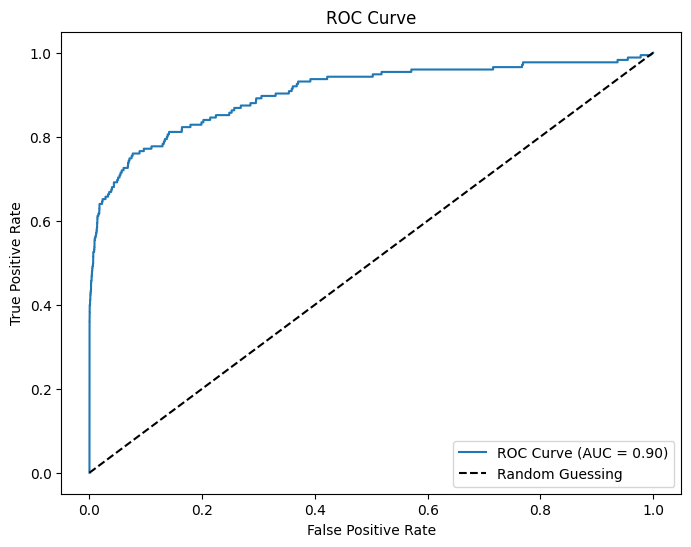

In [21]:
preds = predictions.select("isFraud", "probability").collect()
y_true = [int(row["isFraud"]) for row in preds]
y_scores = [row["probability"][1] for row in preds]

fpr, tpr, _ = roc_curve(y_true, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(test_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve

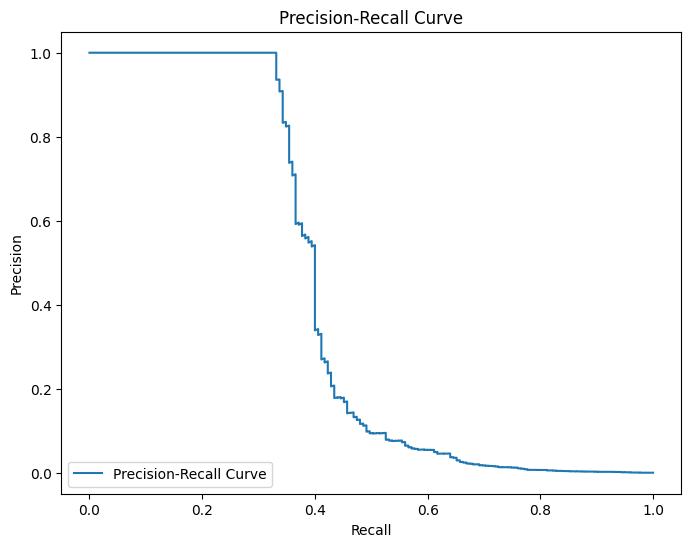

In [23]:
precision, recall, _ = precision_recall_curve(y_true, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


# Confusion Matrix

In [29]:
predictions.printSchema()
predictions.select("features", "isFraud", "prediction", "probability").show(5)

# Extract the predictions and labels
preds = predictions.select("isFraud", "prediction", "probability").collect()

root
 |-- features: vector (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

+--------------------+-------+----------+--------------------+
|            features|isFraud|prediction|         probability|
+--------------------+-------+----------+--------------------+
|(9,[0,2,3,6],[15....|      0|       0.0|[0.99912162678636...|
|[1.0,0.0,9536.54,...|      0|       0.0|[0.99948509858860...|
|[1.0,0.0,14121.82...|      0|       0.0|[0.99934028496911...|
|[1.0,0.0,29587.32...|      0|       0.0|[0.99987731667186...|
|[1.0,0.0,68051.17...|      0|       0.0|[0.99990276013399...|
+--------------------+-------+----------+--------------------+
only showing top 5 rows



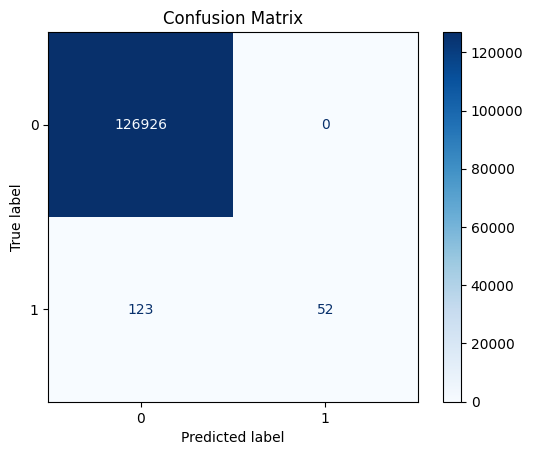

In [30]:
if 'prediction' in predictions.columns:
    y_true = [int(row["isFraud"]) for row in preds]
    y_pred = [int(row["prediction"]) for row in preds]
    y_scores = [row["probability"][1] for row in preds]

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
